## Model selection 

Librairies

In [1]:
import utilities
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import re
import sklearn
import random
import textdistance
import umap
import pickle

from sklearn.tree              import DecisionTreeClassifier
from sklearn.model_selection   import train_test_split
from sklearn                   import metrics
from sklearn.model_selection   import GridSearchCV
from transformers              import BertTokenizer, BertModel
from sentence_transformers     import SentenceTransformer
from sklearn.metrics           import roc_curve
from umap                      import UMAP
from typing                    import Optional
from sklearn.decomposition     import PCA
from sklearn.linear_model      import LogisticRegression
from sklearn.metrics           import confusion_matrix

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\a.tekiouk\AppData\Local\Programs\Py

Import data

In [3]:
chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/DATA/chanel_junk_valid_2.xlsx')
ENCODER_ID = "all-MiniLM-L6-v2"
encoder = SentenceTransformer(ENCODER_ID)

X = encoder.encode(chanel_junk_valid_new['text'])
y = chanel_junk_valid_new['is_junk']

#### Selection using AUC 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.tekiouk\AppDa

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:491: LinAlgWarning: The inner s

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits faile

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

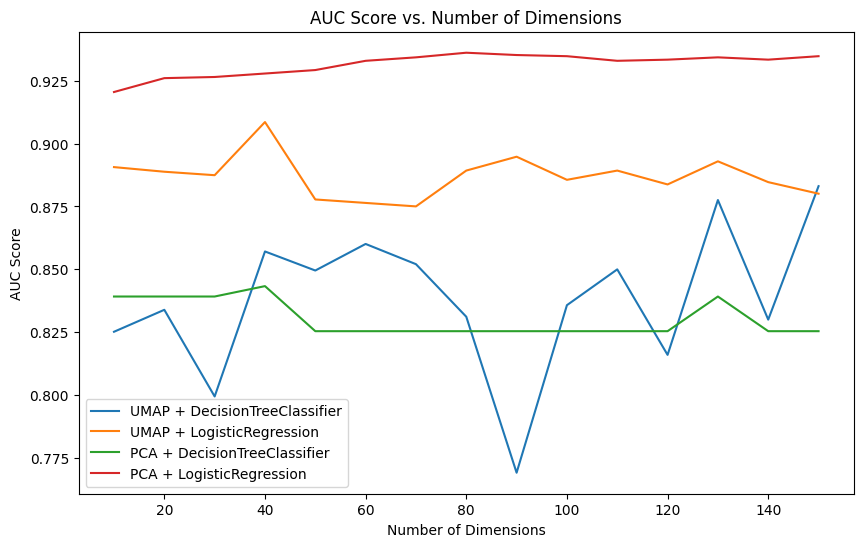

best model : LogisticRegression(max_iter=1000, random_state=42), hyperparameters = {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
AUC : 0.9361213235294118
Optimal number of dimensions : 80
Best reducing method : PCA(n_components=80)


In [3]:
best_model_auc,best_auc,opt_dim,reducer = utilities.auto_model_selection(
    X=X,
    y=y,
    dimension_range=range(10,160,10))
print(f"best model : {best_model_auc}, hyperparameters = {best_model_auc.get_params()}\nAUC : {best_auc}\nOptimal number of dimensions : {opt_dim}\nBest reducing method : {reducer}")

**model** :LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')  
**dimensions** : PCA(90)

*Serialization*

In [4]:
with open('C:/Users/a.tekiouk/Sujet_2/Models/model_auc.pkl', 'wb') as f:  # open a text file
    pickle.dump(best_model_auc, f) # serialize the model
with open('C:/Users/a.tekiouk/Sujet_2/Models/opt_reducer.pkl', 'wb') as f:  # open a text file
    pickle.dump(reducer, f) # serialize the reducer

#### Optimization using precision

In [3]:
# with open('C:/Users/a.tekiouk/Sujet_2/Sujet_2/Models/model_auc.pkl', 'rb') as f:
#     best_model_auc = pickle.load(f) # deserialize using load()
# with open('C:/Users/a.tekiouk/Sujet_2/Sujet_2/Models/opt_reducer.pkl', 'rb') as f:
#     reducer = pickle.load(f) # deserialize using load()

In [5]:
pre_X_train, pre_X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train = reducer.transform(pre_X_train)
X_test = reducer.transform(pre_X_test)

AUC : 0.936
Accuracy score : 0.900
Precision score : 0.923
Recall score : 0.750


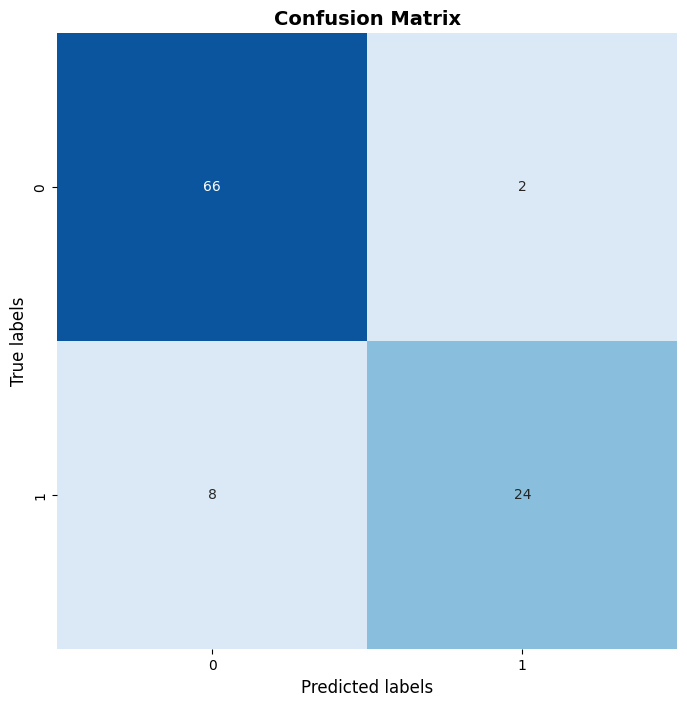

In [6]:
utilities.evaluate(y_test,best_model_auc.predict(X_test),best_model_auc.predict_proba(X_test)[:, 1])

Adapting probability threshold to classify a post as "junk"

In [7]:
threshold = 0.50
y_p2 = best_model_auc.predict(X_train)
y_score = best_model_auc.predict_proba(X_train)
print(f"Recall : {metrics.recall_score(y_train, best_model_auc.predict(X_train))}")
print(f"Precision : {metrics.precision_score(y_train, best_model_auc.predict(X_train))}")
while (metrics.recall_score(y_train, y_p2)>0.65):
    threshold = threshold+0.01
    y_p2 = np.where(y_score[:, 1] > threshold, 1, 0)

print(f"Threshold : {threshold}")
print(f"Recall : {metrics.recall_score(y_train, y_p2)}")
print(f"Precision : {metrics.precision_score(y_train, y_p2)}")
# Threshhold proba : 0.56

Recall : 0.7086092715231788
Precision : 0.8991596638655462
Threshold : 0.54
Recall : 0.6490066225165563
Precision : 0.9423076923076923


AUC : 0.936
Accuracy score : 0.900
Precision score : 0.923
Recall score : 0.750


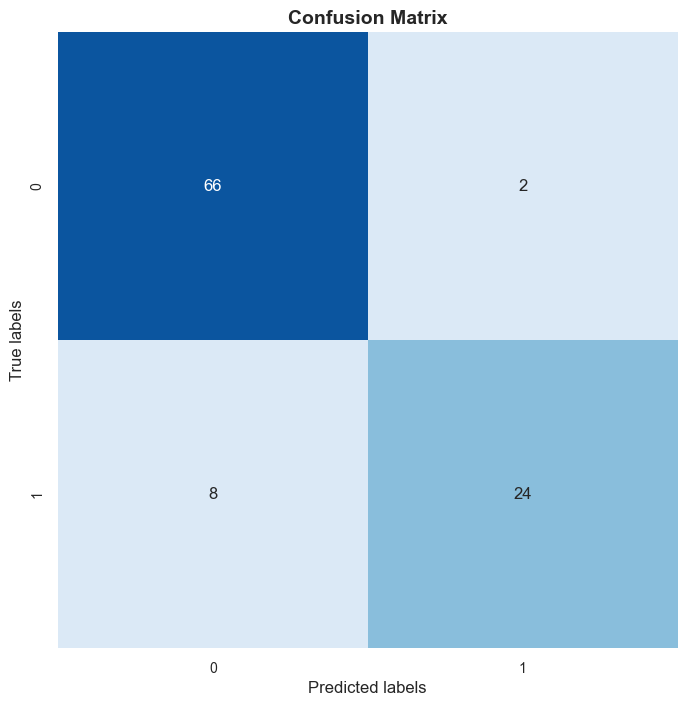

In [18]:
y_p_f = np.where(best_model_auc.predict_proba(X_test)[:, 1] > 0.5, 1, 0)
utilities.evaluate(y_test,y_p_f,best_model_auc.predict_proba(X_test)[:, 1])

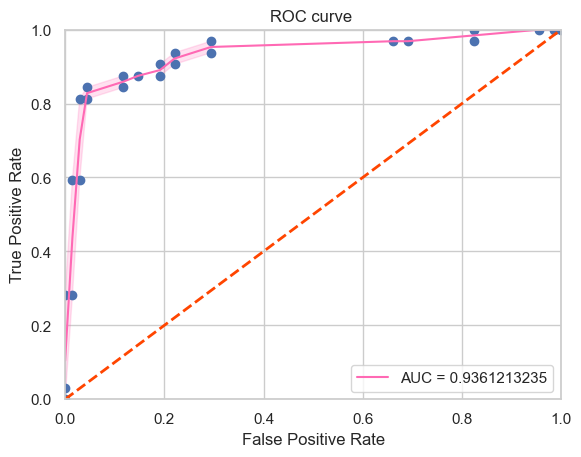

In [9]:
utilities.plot_roc(y_test,best_model_auc.predict_proba(X_test)[:, 1])

Misclassified observations

In [10]:
X_2 = pd.DataFrame(X)
X_2['id'] = chanel_junk_valid_new['id']

In [11]:
_, pre_X_test_2, _, y_test = train_test_split(X_2,y, test_size=0.2, random_state=42)

In [12]:
id_test = pre_X_test_2['id']

In [13]:
id_pred = pd.DataFrame({'id' : id_test, 'y_pred' : best_model_auc.predict(X_test)})

In [14]:
final_text_pred = pd.merge(id_pred,chanel_junk_valid_new[['text','id','is_junk']], on='id')

In [15]:
final_text_pred

,id,y_pred,text,is_junk
0,361,0,inshapeoutfits,1
1,73,1,🤍\n21系列\n\nItem number: 2482\nSize: 19x15x7cm\...,1
2,374,0,Alfie Delevingne today 💘,0
3,155,0,First lady and her son welcome a 19.5-foot b...,0
4,104,1,Leather & Denim \n\nPerf (old) \nJupe \nSola...,0
...,...,...,...,...
95,347,1,💙gros craquage sur ce jeans à Paris 💙vous aime...,1
96,86,1,Život je dar. Každé ráno vstaň a pripomeň si t...,1
97,75,1,【information】\n\nNEW YORK JOE expensiveは4月29日(...,1
98,438,0,Business attire on Tuesday 👀☀️,0


In [16]:
final_text_pred[final_text_pred['y_pred']!=final_text_pred['is_junk']][['y_pred','is_junk','text']]

,y_pred,is_junk,text
0,0,1,inshapeoutfits
4,1,0,Leather & Denim \n\nPerf (old) \nJupe \nSola...
11,0,1,Wow Our Kala Set in Pink is a Stunner 💞💫 Ladie...
21,0,1,served up look-after-look for her multi-event ...
22,0,1,Hair and makeup bellaartistryy29 \n___________...
30,0,1,diddy attended the game last night with recor...
41,1,0,🥂🎤🌪💥\n\n#뉴진스 \n 22.08.03
60,0,1,[💅🏻] JENNIE ile ilgili 5 arama konusu şu anda ...
63,0,1,mi reina🖤
79,0,1,Iconic Pearl chanel 🤍\n\n📲DM to shop


### Evaluation of chatGPT classification results

In [10]:
chatgpt_results = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/DATA/chatgpt_results2.xlsx')
y_chatgpt = chatgpt_results['is_junk'].tolist()

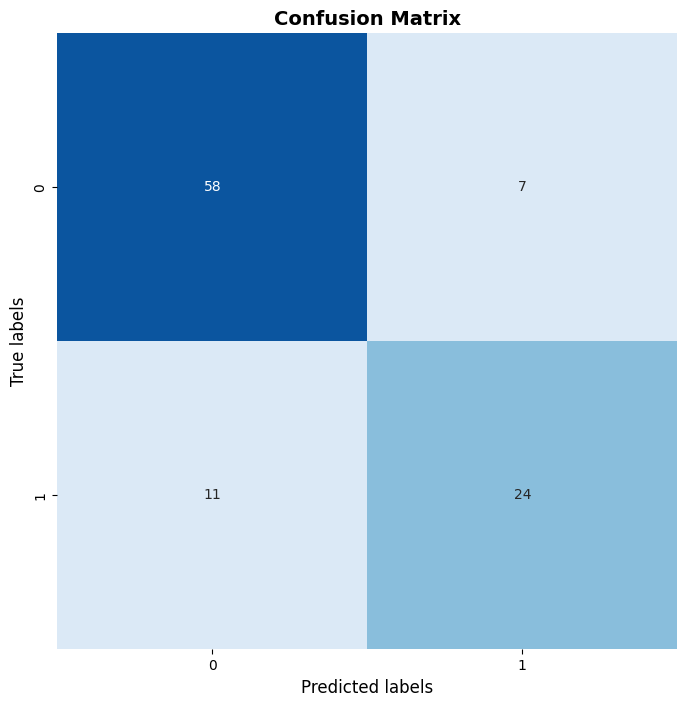

Recall    : 0.6857142857142857
Precision : 0.7741935483870968


In [11]:
y_true = y[0:100]
utilities.plot_confusion_matrix(y_true=y_true,
                                y_pred=y_chatgpt)
print(f"Recall    : {confusion_matrix(y_true, y_chatgpt)[1][1]/(confusion_matrix(y_true, y_chatgpt)[1][1]+confusion_matrix(y_true, y_chatgpt)[1][0])}\nPrecision : {confusion_matrix(y_true, y_chatgpt)[1][1]/(confusion_matrix(y_true, y_chatgpt)[1][1]+confusion_matrix(y_true, y_chatgpt)[0][1])}")

In [49]:
chatgpt_errors = chatgpt_results.loc[np.where(y_chatgpt!=y_true)]
for i in range(0,chatgpt_errors.shape[0]):
    print(chatgpt_errors.iloc[i]['text'])
    print("-------------------------------------------------")
    if chatgpt_errors.iloc[i]['is_junk'] == 1:
        print("Classé junk au lieu de non-junk\n\n\n\n\n")
    elif chatgpt_errors.iloc[i]['is_junk'] == 0:
        print("Classé non-junk au lieu de junk\n\n\n\n\n")
    

S O P H I E  L E  G E N D R E

Photography sophie_le_gendre

chanelofficial
-------------------------------------------------
Classé junk au lieu de non-junk





She judges it fr
-------------------------------------------------
Classé junk au lieu de non-junk





chanel23s
-------------------------------------------------
Classé non-junk au lieu de junk





Dino and Chanely went on an adventure today…..swipe to see their nonsense…although mostly Dino’s nonsense. He’s now got insomnia from too much coffee. Also the new World of Color is fantastic and you should see it. Just remember to bring more extra layers than I did because it gets chilly! Or a blanket. I should have just brought a blanket. 😂
✨
Dress & Hat are Unique Vintage (although I have this dress in many colors but the fabric just isn’t holding up well), cardigan is Tracy Reese (that I’ve had since 2010), shoes are Christian Louboutin that I strassed in 6 stone colors, handbag is Chanel and of COURSE Dino is from Animal Ki